# Example 5.1 Modeling CSV data with Multilayer Perceptron Networks

## Configure imports

In [40]:
import tensorflow.python.platform
import tensorflow as tf
import pandas as pd
import numpy as np

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from matplotlib import pyplot

print("Example 5.1 with TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))



Example 5.1 with TensorFlow version: 2.3.0
Eager execution: True


The data used in this example is artifical, two parameter data of two different labels.

We are going to read a few lines from one of the data files to determine how the data is organized.

In [41]:
path_prefix = os.path.join("data", "classification-simdata")
# filenameTrain = os.path.join(path_prefix, "saturn_data_train.csv")
# filenameTest = os.path.join(path_prefix, "saturn_data_eval.csv")
filenameTrain = "saturn_data_train.csv"
filenameTest = "saturn_data_eval.csv"

# Data by Dr. Jason Baldridge (http://www.jasonbaldridge.com) to test neural network frameworks.
# Read "https://github.com/jasonbaldridge/try-tf/tree/master/simdata" and copy
# to data/classification-simdata
if not os.path.isdir(path_prefix):
     print("Missing Saturn simulation data!")
     printf("Downloading from https://github.com/jasonbaldridge/try-tf/tree/master/simdata")

fd = open(os.path.join(path_prefix, filenameTrain))
for i in range(5):
    print(fd.readline())
fd.close()

1,-7.1239700674365,-5.05175898010314

0,1.80771566423302,0.770505522143023

1,8.43184823707231,-4.2287794074931

0,0.451276074541732,0.669574142606103

0,1.52519959303934,-0.953055551414968



Here, we can see tha the file is arranged into three columns. The first column is the label of the two different groups of data (group 0 and group 1). The second column is are the two features. We will assume that these two features are simply the coordinates of the point that is in the labeled group; i.e., x and y. 


In [42]:
# Extract tf.data.Dataset representations of labels and features in CSV files
# given data in the format of label, feat[0], feat[1]. feat[2], etc..
def get_dataset(file_path, plotDataset=False):
    tf.keras.backend.set_floatx('float64')

    # The raw data from the file is easily loaded as a Pandas DataFrame
    df = pd.read_csv(file_path, header=None)

    # The first column is the column of classification labels. Peel off the column of labels as a 
    # vector of 64 bit floating point values.
    labels = df.pop(0).astype(np.float64)

    dataset_length = len(labels)

    # The remainder of the values are the features
    feat = df.values

    if plotDataset:
        pyplot.figure()
        # There are only two labels in this dataset 0 or 1
        idx = labels > 0.5
        pyplot.scatter(feat[idx, 0], feat[idx, 1], marker='+', c='#ff0000')
        idx = labels <= 0.5
        pyplot.scatter(feat[idx, 0], feat[idx, 1], marker='o', c='#00ff00')
        pyplot.show()

    # Assuming that a value of zero is a label, the number of labels it the maximum integer in the array, plus 1
    NUM_LABELS = np.max(labels) + 1

    # Convert the integer lables into a one hot encoding matrix
    labels_onehot = (np.arange(NUM_LABELS) == labels[:, None]).astype(np.float64)
    
    # A tf.data.Dataset represents a sequence of elements, where each element consists of the data and the data label.
    # See: https://www.tensorflow.org/guide/data
    # As one-hot encoded data...
    dataset = tf.data.Dataset.from_tensor_slices((feat, labels_onehot))

    # The Dataset object is Python iterable.
    return dataset, dataset_length

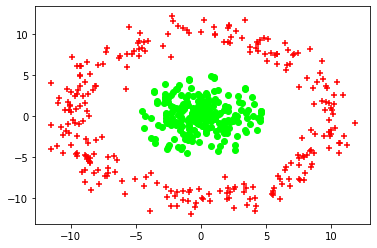



Training data set.
Features: [-7.12397007 -5.05175898], Target: [0. 1.]
Features: [1.80771566 0.77050552], Target: [1. 0.]
Features: [ 8.43184824 -4.22877941], Target: [0. 1.]
Features: [0.45127607 0.66957414], Target: [1. 0.]
Features: [ 1.52519959 -0.95305555], Target: [1. 0.]


Testing data set.
Features: [-2.95364441  0.42407242], Target: [1. 0.]
Features: [9.05324339 3.83322993], Target: [0. 1.]
Features: [-9.41898809 -5.15292208], Target: [0. 1.]
Features: [0.02591421 0.01317695], Target: [1. 0.]
Features: [-5.98582112  9.74872712], Target: [0. 1.]





In [43]:

# Load the training data set
raw_train_data, raw_train_data_length = get_dataset(os.path.join(path_prefix, filenameTrain), plotDataset=True)

print("\n\nTraining data set.")
for feat, targ in raw_train_data.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

# Load the test/evaluation data set
raw_test_data, raw_test_data_length = get_dataset(os.path.join(path_prefix, filenameTest))

print("\n\nTesting data set.")
for feat, targ in raw_test_data.take(5):
    print ('Features: {}, Target: {}'.format(feat, targ))

print("\n\n")

Next, make the regression model to predict the label. For this example, the model has two layers. The input layer is an multilayer perceptron network with an RELU activation function and the output layer is is a softmax activation function with a negative log likelihood loss function. 

The weight initializer from the Deep Learning book is Xavier.

In [44]:

seed = 123
LEARNING_RATE = 0.005
BATCH_SIZE = 50
NUM_EPOCHS = 30 # Number of epochs, full passes of the data
NUM_INPUTS = 2
NUM_OUTPUTS = 2
NUM_HIDDEN_NODES = 20

# Build the model.
model = Sequential([
    tf.keras.layers.Dense(NUM_HIDDEN_NODES, activation='relu'),
    tf.keras.layers.Dense(NUM_OUTPUTS, activation='softmax')
])

# For this example, we need to calcualte the negative log likelihood of the model given the data
# To do this with Keras, we need to create a class that inhertis from the tf.keras.losses.Loss class 
# and implement the following two methods:
#   __init__(self) —Accept parameters to pass during the call of your loss function
#   call(self, y_true, y_pred) —Use the targets (y_true) and the model predictions (y_pred) to compute the model's loss
#
# See: 
class NegLogLikelihood(tf.keras.losses.Loss):
    """Loss class calcuates the negative log likelihood of the model, given the data.
    
    Arguments:
        model -- The Keras neural network model
        reduction -- Type of tf.keras.losses.Reduction to apply to loss.
        name -- Name of the loss function.
    """
    def __init__(self, model, reduction=tf.keras.losses.Reduction.AUTO, name='nll_gausian'):
        super().__init__(reduction=reduction, name=name)
        self.model = model

    """Need to convert the loss function below to a 
    loss function suitable to the above input parameters.

    Likelihood is the probability that the calculated parameters
    produced the known data. Probability of the parameters (model)
    given the data.

    Likelihood:
    L = Product i=1..N p(x(i) | theta)

    NLL:
    NLL = Sum i=1..N -log(p(x(i) | theta))

    where, p(x(i) | theta) is the gausian probability density function
    """
    def call(self, y_true, y_pred):
        print("y_true:", y_true, ", y_pred:", y_pred)
        y_pred_mean = tf.math.reduce_mean(y_pred, axis=-1)
        y_pred_sd = tf.math.reduce_std(y_pred, axis=-1)

        print("mean:", y_pred_mean, ", sd:", y_pred_sd)

        ## element wise square
        square = tf.square(y_pred_mean - y_true)## preserve the same shape as y_pred.shape
        ms = tf.add(tf.divide(square,y_pred_sd), tf.math.log(y_pred_sd))
        ## axis = -1 means that we take mean across the last dimension 
        ## the output keeps all but the last dimension
        ## ms = tf.reduce_mean(ms,axis=-1)
        ## return scalar
        ms = tf.reduce_mean(ms)
        print("ms:", ms)
        return(ms)

# To train using the Dataset, we should shuffle and batch the data
training_batches = raw_train_data.shuffle(raw_train_data_length).batch(BATCH_SIZE)

model.compile(loss = tf.losses.MeanSquaredError(), optimizer = tf.optimizers.Adam(), metrics=['accuracy'])

# Optimizer is stochastic gradient descent (sgd), loss function is negative log likelihood
# model.compile(optimizer='sgd', loss=NegLogLikelihood(model), metrics=['accuracy'])

#history = model.fit(train_feat, train_labels, epochs=NUM_EPOCHS, verbose=1, batch_size=BATCH_SIZE)
history = model.fit(training_batches, epochs=NUM_EPOCHS, verbose=1)
model.summary()

Epoch 1/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2915 - accuracy: 0.5200
Epoch 2/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2591 - accuracy: 0.5600
Epoch 3/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2303 - accuracy: 0.6180
Epoch 4/30
10/10 [==============================] - 0s 3ms/step - loss: 0.2085 - accuracy: 0.6380
Epoch 5/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.6620
Epoch 6/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.6900
Epoch 7/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.7100
Epoch 8/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1494 - accuracy: 0.7420
Epoch 9/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1420 - accuracy: 0.7780
Epoch 10/30
10/10 [==============================] - 0s 3ms/step - loss: 0.1353 - accuracy: 0.8120
Epoch 11/30
10/10 [

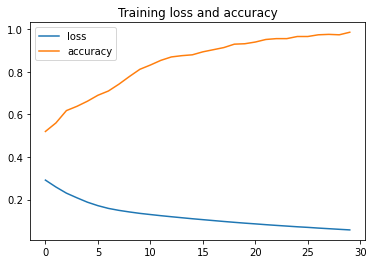

In [45]:
# plot history
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['accuracy'], label='accuracy')
pyplot.title('Training loss and accuracy')
pyplot.legend()
pyplot.show()


In [47]:
# Run against the test set. Final evaluation of the model
testing_batches = raw_test_data.shuffle(raw_test_data_length).batch(BATCH_SIZE)
scores = model.evaluate(testing_batches, verbose=0)
print("Test set analysis accuracy: %.2f%%" % (scores[1]*100))

Test set analysis accuracy: 99.00%
